In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
from matplotlib.patheffects import withStroke

from myconfig import ROOT_DIR

In [2]:
ml_bacteria = pd.read_csv(ROOT_DIR/'results'/'bacteria-CV-main.tsv', sep='\t', index_col=0)
ml_bacteria.loc[ml_bacteria['ncat'].eq(1), 'model'] = 'plane'

ml_fish = pd.read_csv(ROOT_DIR/'results'/'fish-CV-main.tsv', sep='\t', index_col=0)
ml_fish.loc[ml_fish['ncat'].eq(1), 'model'] = 'plane'

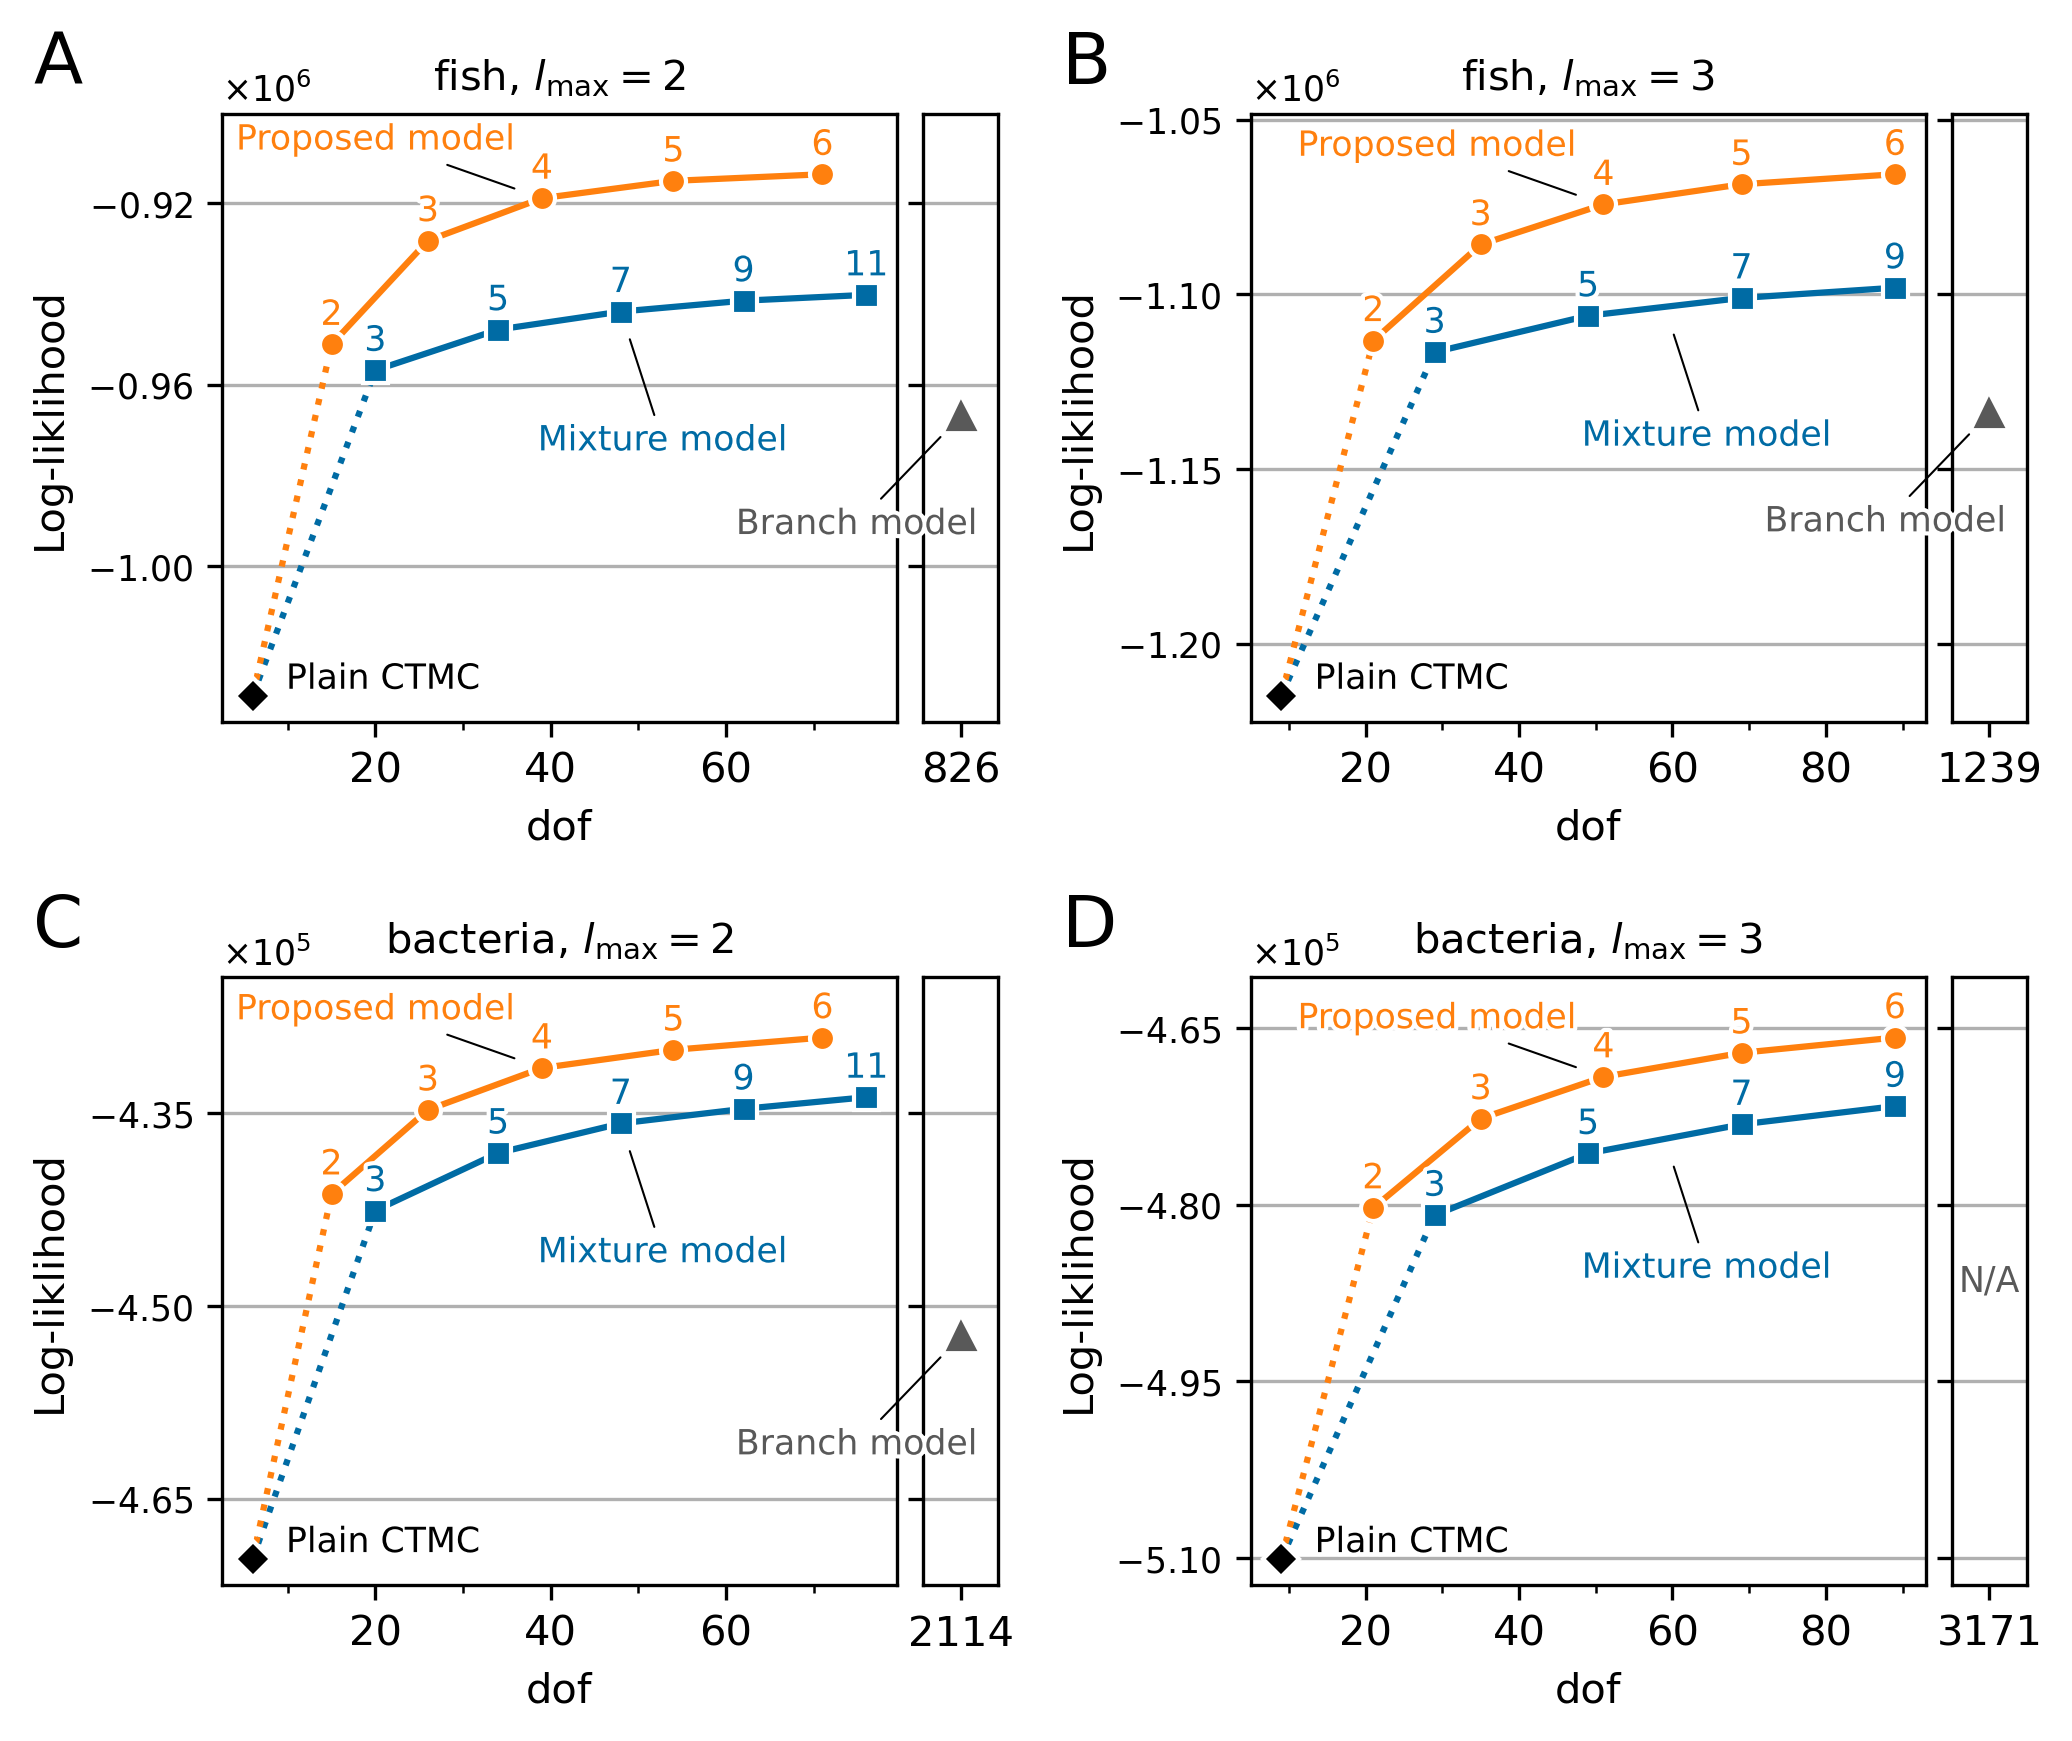

In [4]:
mm = 1 / 25.4

fig = plt.figure(figsize=(178*mm, 150*mm), dpi=300, layout='tight')
gs = fig.add_gridspec(2, 2)
axesA = 'A', gs[0, 0].subgridspec(1, 2, width_ratios=[9,1], wspace=0.07).subplots(sharey=True)
axesB = 'B', gs[0, 1].subgridspec(1, 2, width_ratios=[9,1], wspace=0.07).subplots(sharey=True)
axesC = 'C', gs[1, 0].subgridspec(1, 2, width_ratios=[9,1], wspace=0.07).subplots(sharey=True)
axesD = 'D', gs[1, 1].subgridspec(1, 2, width_ratios=[9,1], wspace=0.07).subplots(sharey=True)

for name, df, axr in [('fish'    , ml_fish    , (axesA, axesB)), 
                      ('bacteria', ml_bacteria, (axesC, axesD))]:
    for (lmax, grp), (label, (ax, axsub)) in zip(df.groupby('lmax'), axr):
        plane  = grp[grp['model'].eq('plane' )].copy()
        branch = grp[grp['model'].eq('branch')].copy()
        mirage = grp[grp['model'].eq('mirage')].copy()
        mmm    = grp[grp['model'].eq('mmm'   )].copy()

        pltkw = dict(x='dof', y='loglik_test', ax=ax, zorder=2, legend=False)
        pd.concat([plane, mirage.head(1)]).plot(c='C0', ls=':', **pltkw)
        pd.concat([plane, mmm   .head(1)]).plot(c='C1', ls=':', **pltkw)
        plane .plot(marker='D', c='k' , mec='w', **pltkw)
        mirage.plot(marker='s', c='C0', mec='w', **pltkw)
        mmm   .plot(marker='o', c='C1', mec='w', **pltkw)

        branch.plot(x='dof', y='loglik_test', marker='^', c='C3', ax=axsub, legend=False)

        annotkw = dict(
            ha='center', va='bottom', textcoords='offset points', fontsize='small', 
            path_effects=[withStroke(linewidth=2, foreground='w')]
        )
        for record in mirage.itertuples():
            ax.annotate(
                record.nmixt, (record.dof, record.loglik_test), 
                xytext=(0, 3), c='C0', **annotkw
            )
        for record in mmm.itertuples():
            ax.annotate(
                record.ncat, (record.dof, record.loglik_test), 
                xytext=(0, 3), c='C1', **annotkw
            )

        ax.annotate(
            'Plain CTMC', *plane[['dof', 'loglik_test']].values, 
            xytext=(8, 0), **annotkw | dict(ha='left')
        )
        ax.annotate(
            'Mixture model', 
            mirage[['dof','loglik_test']].median(), 
            xytext=(10, -35), c='C0', **annotkw, 
            arrowprops=dict(arrowstyle='-',lw=0.5, shrinkA=0, shrinkB=7)
        )
        ax.annotate(
            'Proposed model', 
            mmm[['dof','loglik_test']].median(), 
            xytext=(-40, 10), c='C1',**annotkw, 
            arrowprops=dict(arrowstyle='-',lw=0.5, shrinkA=0, shrinkB=7)
        )

        ax.set_title(f'{name}, $l_\max={lmax}$', fontsize='medium')

        ax.xaxis.set_major_locator(plt.MultipleLocator(20))
        ax.xaxis.set_minor_locator(plt.MultipleLocator(10))

        y0, y1 = ax.get_ybound()
        ax.set_ybound(upper=(y1 - y0) * 0.06 + y1)
        ax.set_ylabel('Log-liklihood')
        ax.yaxis.set_tick_params(labelsize='small')
        ax.yaxis.set_tick_params(which='minor', left=False)            
        ax.yaxis.get_major_formatter().set_useMathText(True)
        ax.yaxis.get_major_formatter().set_powerlimits((-3, 5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ax.yaxis.get_offset_text().set_fontsize('small')
        ax.yaxis.grid()

        (dof, loglik),  = branch[['dof','loglik_test']].values
        if np.isnan(loglik):
            axsub.text(
                0.5, 0.5, 'N/A', ha='center', va='center', 
                c='C3', fontsize='small', transform=axsub.transAxes
            )
        else:
            axsub.annotate(
                'Branch model', (dof, loglik), 
                xytext=(-25, -30), c='C3', **annotkw, 
                arrowprops=dict(arrowstyle='-',lw=0.5, shrinkA=0, shrinkB=7)
            )

        axsub.set_xlim(dof - 0.5, dof + 0.5)    
        axsub.set_xlabel(None)
        axsub.set_xticks(branch['dof'])
        axsub.yaxis.set_tick_params(which='minor', left=False)            
        axsub.yaxis.grid()

        ax.text(-0.28, 1.05, label, transform=ax.transAxes, size='xx-large')
        
#fig.savefig('jpg/cv-loglik-main.jpg', bbox_inches='tight', dpi=350)
#fig.savefig('png/cv-loglik-main.png', bbox_inches='tight', dpi=350)
#fig.savefig('pdf/cv-loglik-main.pdf', bbox_inches='tight')
fig.savefig('eps/cv-loglik-main.eps', bbox_inches='tight')